In [18]:
#!pip install numpy pandas matplotlib scikit-learn tensorflow keras

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import os

## Carregando os dados e colocando a coluna 'Date' como índice

In [33]:
caminho_pasta = 'Base_dados'
lista_arquivos = [arquivo for arquivo in os.listdir(caminho_pasta) if os.path.isfile(os.path.join(caminho_pasta, arquivo))]

for arq in lista_arquivos:
    df = pd.read_csv(f'Base_dados/{arq}')
    df = df.sort_values('Date')
    # Verificar se a coluna 'Date' existe e definir como índice
    if 'Date' in df.columns:
        df = df.set_index('Date')
    print(df.head())


        Date    Open       High        Low      Close  Adj Close      Volume  \
0 2020-01-29  25.500  25.690001  24.680000  24.730000  18.055990  16800400.0   
1 2020-01-30  24.350  24.995001  24.184999  24.900000  18.180117  25079800.0   
2 2020-01-31  24.555  24.559999  24.110001  24.270000  17.720137  32252800.0   
3 2020-02-03  24.275  24.570000  24.004999  24.389999  17.807749  20402800.0   
4 2020-02-04  24.645  24.799999  24.125000  24.125000  17.614269  23533200.0   

    SMA_10     EMA_10     RSI_10      MACD  MACD_Histogram  BBL_20_2.0  \
0  24.9610  25.132101  40.316762 -0.407259        0.043456   23.842415   
1  24.9785  25.089901  43.272728 -0.397243        0.042777   23.898938   
2  24.8995  24.940828  35.942692 -0.435126        0.003916   23.906795   
3  24.8485  24.840677  38.159656 -0.450275       -0.008986   23.925546   
4  24.8430  24.710554  35.172752 -0.478152       -0.029490   23.906871   

   BBM_20_2.0  BBU_20_2.0  BBB_20_2.0  BBP_20_2.0   ATRr_14    stoch_k  \


# 1 - Pré-Processamento dos Dados

## 1.1 - Selecionar Colunas Relevantes

In [27]:
#hist_TSLA
data = df['Close'].values

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-01-30   42.161331   43.391998   41.200001   42.720669   42.720669   
2020-01-31   42.666668   43.533333   42.167999   43.371334   43.371334   
2020-02-03   44.912666   52.409332   44.901333   52.000000   52.000000   
2020-02-04   58.863998   64.599335   55.591999   59.137333   59.137333   
2020-02-05   54.883999   56.398666   46.940666   48.980000   48.980000   
...                ...         ...         ...         ...         ...   
2024-09-23  242.610001  250.000000  241.919998  250.000000  250.000000   
2024-09-24  254.080002  257.190002  249.050003  254.270004  254.270004   
2024-09-25  252.539993  257.049988  252.279999  257.019989  257.019989   
2024-09-26  260.600006  261.750000  251.529999  254.220001  254.220001   
2024-09-27  257.380005  260.700012  254.119995  260.459991  260.459991   

                 Volume      SMA_10  

## 1.2 - Normalização dos Dados

In [37]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.reshape(-1, 1))

# 2 - Criação de Sequências para Treinamento

In [38]:
# Defina o tamanho da janela de tempo (por exemplo, 60 dias):
window_size = 60

# Criando sequências de dados
X = []
y = []

for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i-window_size:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

# 3 - Redimensionamento dos Dados

In [16]:
# Redimensionando X para 3 dimensões (necessário para Conv1D)
X = np.expand_dims(X, axis=2)

# 4 - Divisão dos Dados em Treino e Teste

## 4.1 Dividindo os Dados

In [39]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 5 - Construção do Modelo CNN

In [18]:
model = Sequential()

## 5.1 - Adicionando Camadas ao Modelo

In [19]:
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

## 5.2 - Compilando Modelo

In [40]:
model.compile(optimizer='adam', loss='mean_squared_error')

# 6 - Treinamento do Modelo

In [21]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
28/28 [==============================] - 1s 9ms/step - loss: 0.0250 - val_loss: 0.0041
Epoch 2/50
28/28 [==============================] - 0s 5ms/step - loss: 0.0060 - val_loss: 0.0044
Epoch 3/50
28/28 [==============================] - 0s 5ms/step - loss: 0.0036 - val_loss: 0.0019
Epoch 4/50
28/28 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 5/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 6/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 7/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 8/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 9/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 10/50
28/28 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 8.7451e-04
Epoch 11/50
28/

# 7 - Avaliação do Modelo

In [22]:
loss = model.evaluate(X_test, y_test)
print(f'Perda no teste: {loss}')

7/7 [==============================] - 0s 2ms/step - loss: 4.8147e-04
Perda no teste: 0.0004814747371710837


# 8 - Realização de Previsões

In [24]:
predictions = model.predict(X_test)

# Desnormalizar previsões
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

7/7 [==============================] - 0s 2ms/step


# 9 - Visualização dos Resultados

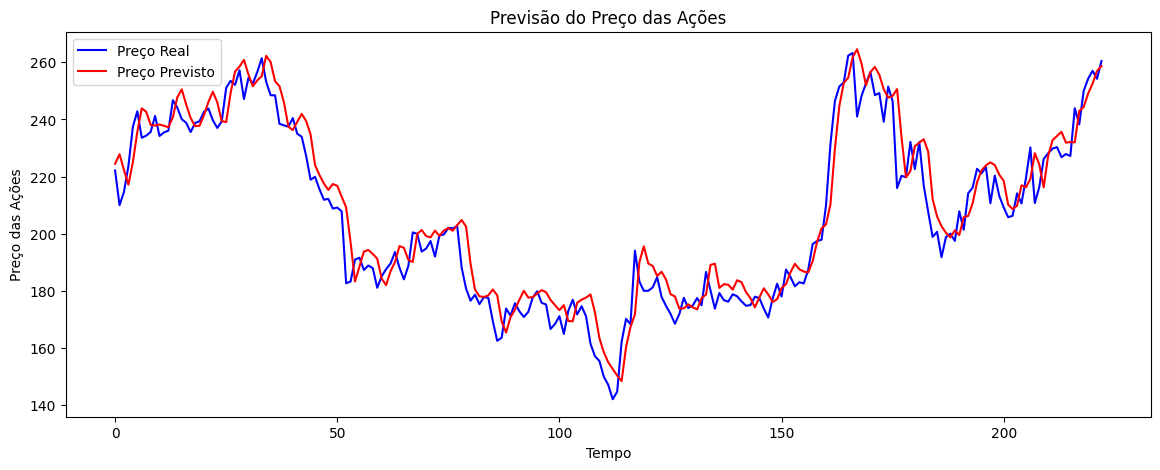

In [25]:
plt.figure(figsize=(14,5))
plt.plot(y_test_actual, color='blue', label='Preço Real')
plt.plot(predictions, color='red', label='Preço Previsto')
plt.title('Previsão do Preço das Ações')
plt.xlabel('Tempo')
plt.ylabel('Preço das Ações')
plt.legend()
plt.show()

# 10 - Cálculo de Métricas de Desempenho

## 10.1 - Calcule MAE e RMSE
MAE (Erro Médio Absoluto)
Definição:
- O MAE calcula a média das diferenças absolutas entre as previsões e os valores reais. Ele indica o quanto, em média, as previsões estão distantes dos valores observados.

Interpretação:
- Valores menores de MAE indicam que o modelo tem melhor desempenho, com previsões mais próximas dos valores reais.
- O MAE é medido nas mesmas unidades dos dados originais (por exemplo, se os preços estão em reais, o MAE também estará em reais).
- É uma métrica intuitiva, fácil de interpretar e não penaliza excessivamente grandes erros individuais.

RMSE (Raiz do Erro Quadrático Médio)
Definição:
- O RMSE calcula a raiz quadrada da média dos quadrados das diferenças entre as previsões e os valores reais. Ele dá mais peso a erros maiores devido ao uso do quadrado das diferenças.

Interpretação:
- Valores menores de RMSE também indicam melhor desempenho do modelo.
- O RMSE é sensível a grandes erros (outliers) devido ao quadrado das diferenças.
- Como o RMSE também está nas mesmas unidades dos dados originais, ele facilita a interpretação prática dos resultados.

In [26]:
mae = mean_absolute_error(y_test_actual, predictions)
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

MAE: 6.518820245169736
RMSE: 8.467375254627237


14. Otimização do Modelo

Ajuste de hiperparâmetros:
- Tente alterar o número de épocas, tamanho do lote, número de filtros, tamanho do kernel, etc.
- Adicionar mais camadas ou regularização:
- Considere adicionar camadas Dropout para evitar overfitting.
15. Documentação e Análise

Documente cada passo:
- Explique as escolhas feitas e os resultados obtidos.

Análise crítica:
- Discuta as limitações do modelo e possíveis melhorias.

Dicas Adicionais
- Validação Cruzada: Considere usar validação cruzada para avaliar melhor o desempenho do modelo.
- Comparação com Outros Modelos: Compare a CNN com outros modelos, como LSTM ou modelos ARIMA.
- Atualização dos Dados: Certifique-se de que os dados estejam atualizados e reflitam o mercado atual.
- Considerações Éticas: Esteja ciente dos riscos associados à previsão de mercados financeiros.